# Homework 

In this homework, we'll deploy the bees vs wasps model we trained in the previous homework.

Download the model from here:

https://github.com/alexeygrigorev/large-datasets/releases/download/wasps-bees/bees-wasps.h5

## Question 1

Now convert this model from Keras to TF-Lite format.

What's the size of the converted model?

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

In [2]:
model = keras.models.load_model('bees-wasps.h5')

In [3]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('bees-wasps.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\daniel\AppData\Local\Temp\tmpbfe61ed7\assets


INFO:tensorflow:Assets written to: C:\Users\daniel\AppData\Local\Temp\tmpbfe61ed7\assets


In [4]:
%ls

 El volumen de la unidad C no tiene etiqueta.
 El número de serie del volumen es: 5E14-D874

 Directorio de c:\Users\daniel\Documents\Universidad\Cursos\MLZoomCamp\09_serverless\Homework9

25/11/2023  10:57 a. m.    <DIR>          .
25/11/2023  10:57 a. m.    <DIR>          ..
24/11/2023  02:21 p. m.        89,753,864 bees-wasps.h5
25/11/2023  11:00 a. m.        44,866,200 bees-wasps.tflite
24/11/2023  04:37 p. m.           100,509 Homework9.ipynb
24/11/2023  05:04 p. m.             1,632 lambda_function.py
24/11/2023  04:25 p. m.               560 test.py
               5 archivos    134,722,765 bytes
               2 dirs  202,185,441,280 bytes libres


## Question 2

To be able to use this model, we need to know the index of the input and the index of the output.

What's the output index for this model?

In [5]:
import tensorflow.lite as tflite

In [6]:
interpreter = tflite.Interpreter(model_path='bees-wasps.tflite') 
interpreter.allocate_tensors() 

input_index = interpreter.get_input_details()[0]['index'] 
output_index = interpreter.get_output_details()[0]['index'] 

print(output_index)

13


## Preparing the image

You'll need some code for downloading and resizing images. You can use this code:

In [10]:
# !pip install Pillow

  Using cached Pillow-10.1.0-cp310-cp310-win_amd64.whl.metadata (9.6 kB)
Using cached Pillow-10.1.0-cp310-cp310-win_amd64.whl (2.6 MB)


In [7]:
from io import BytesIO
from urllib import request

from PIL import Image

def download_image(url):
    with request.urlopen(url) as resp:
        buffer = resp.read()
    stream = BytesIO(buffer)
    img = Image.open(stream)
    return img


def prepare_image(img, target_size):
    if img.mode != 'RGB':
        img = img.convert('RGB')
    img = img.resize(target_size, Image.NEAREST)
    return img

Let's download and resize this image:

https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

Based on the previous homework, what should be the target size for the image?

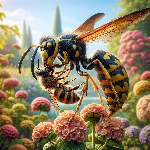

In [8]:
imagen = download_image('https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg')
imagen = prepare_image(imagen, target_size=(150, 150))
imagen

In [9]:
imagen.size

(150, 150)

In [10]:
preprocessed_image = np.array(imagen)/255.
preprocessed_image.shape

(150, 150, 3)

In [11]:
preprocessed_image[0][0][0]

0.9450980392156862

In [12]:
X = np.array([preprocessed_image], dtype='float32')
X.shape

(1, 150, 150, 3)

In [13]:
interpreter.set_tensor(input_index, X)
interpreter.invoke()
preds = interpreter.get_tensor(output_index)

preds

array([[0.6592137]], dtype=float32)

## Prepare the lambda code

Now you need to copy all the code into a separate python file. You will need to use this file for the next two questions.

Tip: you can test this file locally with ipython or Jupyter Notebook by importing the file and invoking the function from this file.

## Docker

For the next two questions, we'll use a Docker image that we already prepared. This is the Dockerfile that we used for creating the image:

FROM public.ecr.aws/lambda/python:3.10
COPY bees-wasps-v2.tflite .

And pushed it to agrigorev/zoomcamp-bees-wasps:v2.

A few notes:

    The image already contains a model and it's not the same model as the one we used for questions 1-4.
    The version of Python is 3.10, so you need to use the right wheel for TF-Lite. For Tensorflow 2.14.0, it's https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.14.0-cp310-cp310-linux_x86_64.whl

## Question 5

Download the base image agrigorev/zoomcamp-bees-wasps:v2. You can easily make it by using docker pull command.

So what's the size of this base image?

In [14]:
!docker images

REPOSITORY                                                            TAG                              IMAGE ID       CREATED        SIZE
393556504128.dkr.ecr.us-east-2.amazonaws.com/clothing-tflite-images   clothing-model-xception-v4-001   3e34a4c6506c   21 hours ago   817MB
393556504128.dkr.ecr.us-east-2.amazonaws.com/clothing-tflite-images   latest                           3e34a4c6506c   21 hours ago   817MB
clothing-model                                                        latest                           3e34a4c6506c   21 hours ago   817MB
agrigorev/zoomcamp-bees-wasps                                         v2                               b9f6c13de368   7 days ago     662MB
zoomcamp-midterm-project                                              latest                           2e4505baf3bd   4 weeks ago    480MB
zoomcamp-hw                                                           latest                           2a31dc818447   6 weeks ago    504MB
zoomcamp-test               

## Question 6

Now let's extend this docker image, install all the required libraries and add the code for lambda.

You don't need to include the model in the image. It's already included. The name of the file with the model is bees-wasps-v2.tflite and it's in the current workdir in the image (see the Dockerfile above for the reference).

Now run the container locally.

Score this image: https://habrastorage.org/webt/rt/d9/dh/rtd9dhsmhwrdezeldzoqgijdg8a.jpeg

What's the output from the model?

In [15]:
!docker build -t zoomcamp-homework9 .

#0 building with "default" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 334B done
#1 DONE 0.0s

#2 [internal] load .dockerignore
#2 transferring context: 2B done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/agrigorev/zoomcamp-bees-wasps:v2
#3 DONE 0.0s

#4 [1/5] FROM docker.io/agrigorev/zoomcamp-bees-wasps:v2
#4 DONE 0.0s

#5 [internal] load build context
#5 transferring context: 40B done
#5 DONE 0.0s

#6 [4/5] RUN pip install https://github.com/alexeygrigorev/tflite-aws-lambda/raw/main/tflite/tflite_runtime-2.14.0-cp310-cp310-linux_x86_64.whl
#6 CACHED

#7 [3/5] RUN pip install Pillow
#7 CACHED

#8 [2/5] RUN pip install numpy
#8 CACHED

#9 [5/5] COPY lambda_function.py .
#9 CACHED

#10 exporting to image
#10 exporting layers done
#10 writing image sha256:e2d31aa0e6040592aa79afb6a7f44588309e8de82ea391bbe27575c1e070ee25 done
#10 naming to docker.io/library/zoomcamp-homework9
#10 naming to docker.io/library/zoomc

In [17]:
!python test.py

[0.4453350603580475]
